### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde as gkde
from sklearn.metrics import precision_recall_curve, f1_score

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [15]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [16]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [17]:
# atn

In [18]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [19]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
# diag

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [21]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [22]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [23]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [24]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [25]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

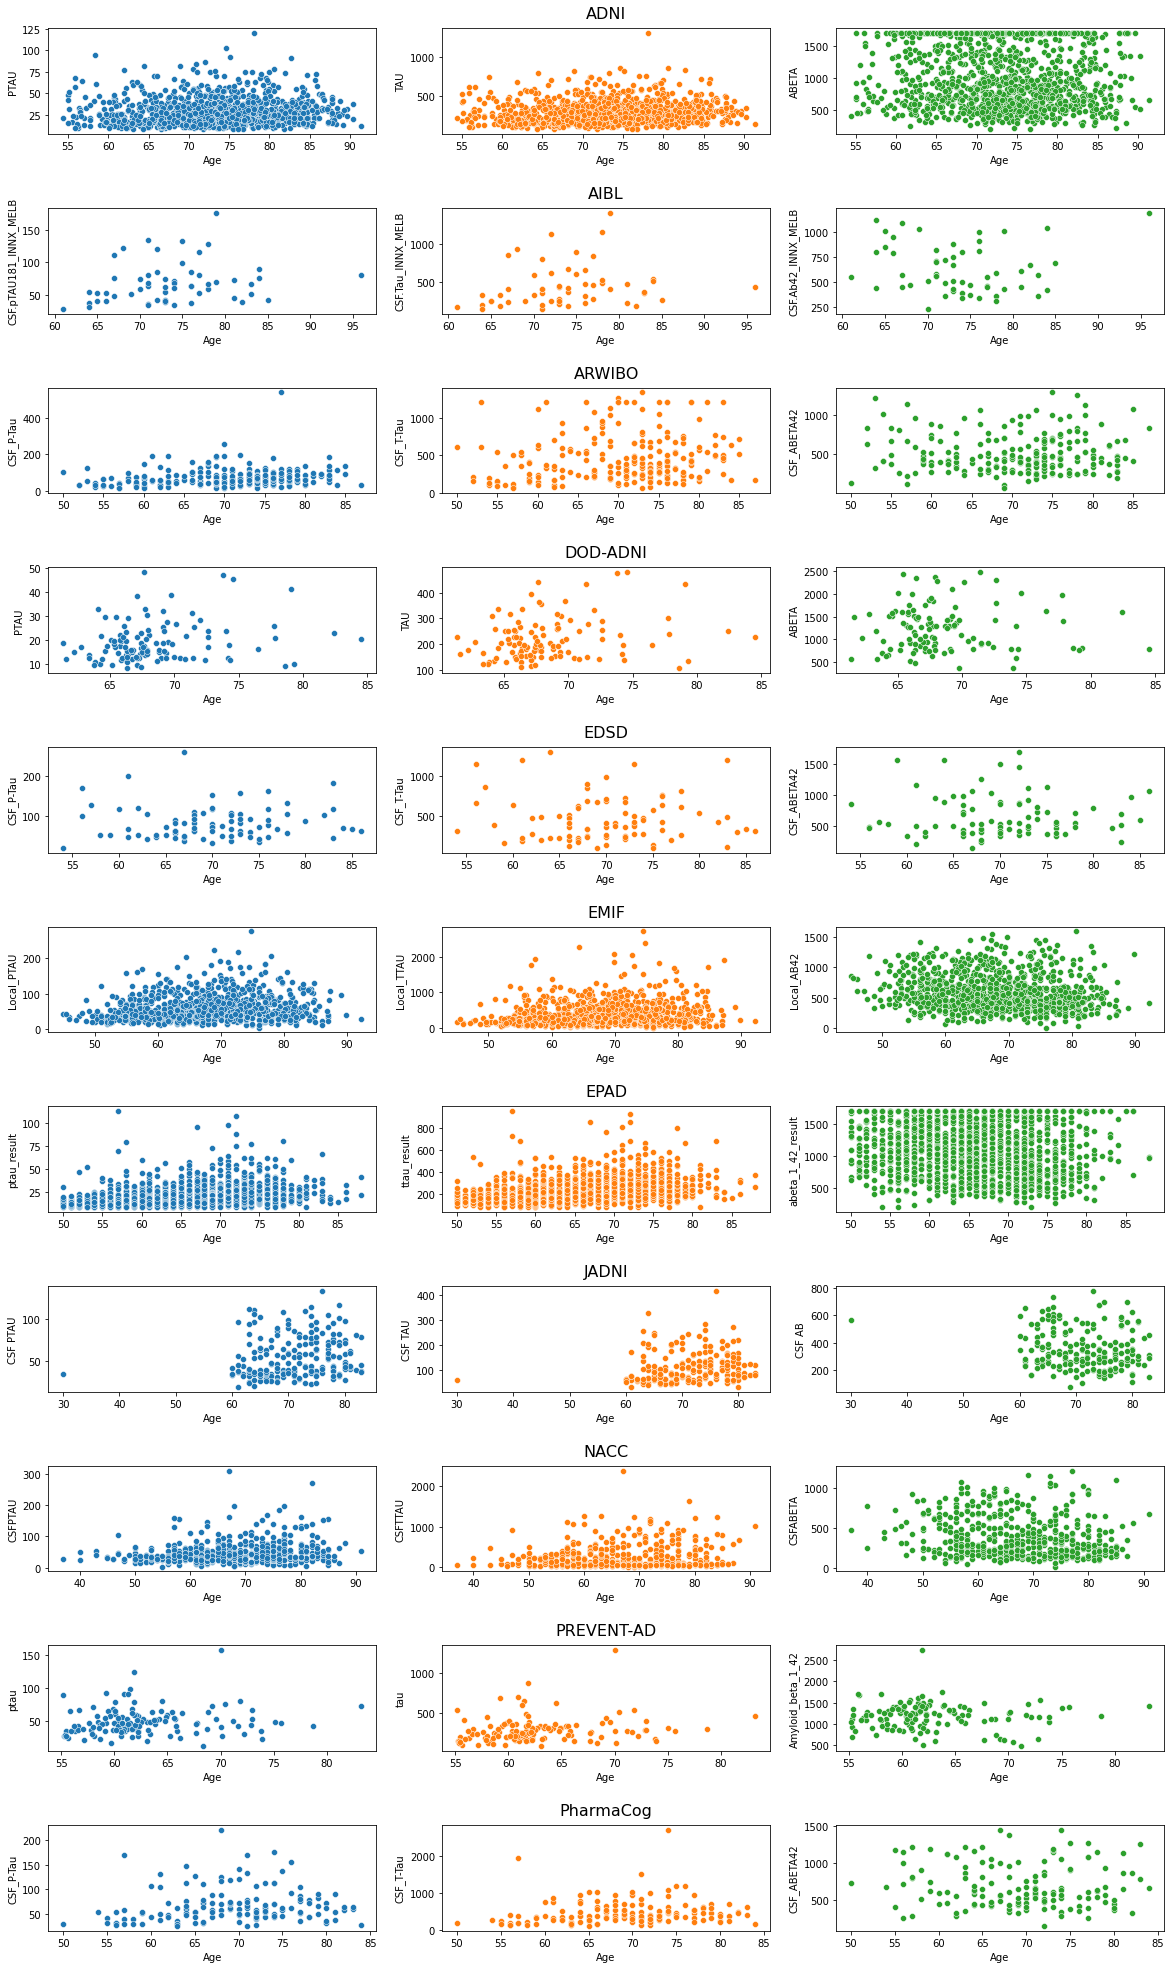

In [26]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### Clustering CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [27]:
cohorts_csf = dict()

for i in atn.index:
    csf = mappings['csf'].iloc[:3][i].to_list()
    cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
    cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
#     for col in ['A', 'T', 'N']:
#         cohorts_csf[i][col]=np.nan

# K-Means Clustering

### Scale CSF Features

In [28]:
# scale each feature and write it as a new column in the respective dataframe
# name the new columns with a suffix "_scaled"
for cohort in cohorts_csf:
    
    for i in cohorts_csf[cohort][cohorts_csf[cohort].columns[:3].to_list() + ['Age']]: 
        cohorts_csf[cohort][i + '_scaled'] = MinMaxScaler().fit_transform(X=cohorts_csf[cohort][[i]])

In [29]:
for i in cohorts_csf:
    if len(cohorts_csf[i][cohorts_csf[i].columns[1]]) != len(cohorts_csf[i]['Age_scaled'].dropna()):
        print(i)

### K-Means Training

In [30]:
hypersss = dict()
silhouette = dict()

for i in cohorts_csf:
    
    # Create empty dictionary for storing hyperparameters (number of clusters)
    hyper = dict()

    
    # Create empty dictionary for storing silhouette scores
    sil_scores = dict()

    # Define different number of clusters to explore
    n_clus = range(2, 5, 1) 

    for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][i].to_list()]:

        clus = list()
        sil = list()

        for n in n_clus:

            # Set the model and its parameter
            model = KMeans(n_clusters=n, n_init=20)
            # Fit the model 
            clm = model.fit(cohorts_csf[i][[biom, 'Age_scaled']])
            lables = clm.predict(cohorts_csf[i][[biom, 'Age_scaled']])
            
            # Calculate BIC Scores and silhouette scores then store them in a dictionaries
            clus.append(n)
            sil.append(metrics.silhouette_score(cohorts_csf[i][[biom, 'Age_scaled']], lables))
            
        hyper[biom] = clus
        sil_scores[biom] = sil
        
    hypersss[i] = hyper
    silhouette[i] = sil_scores

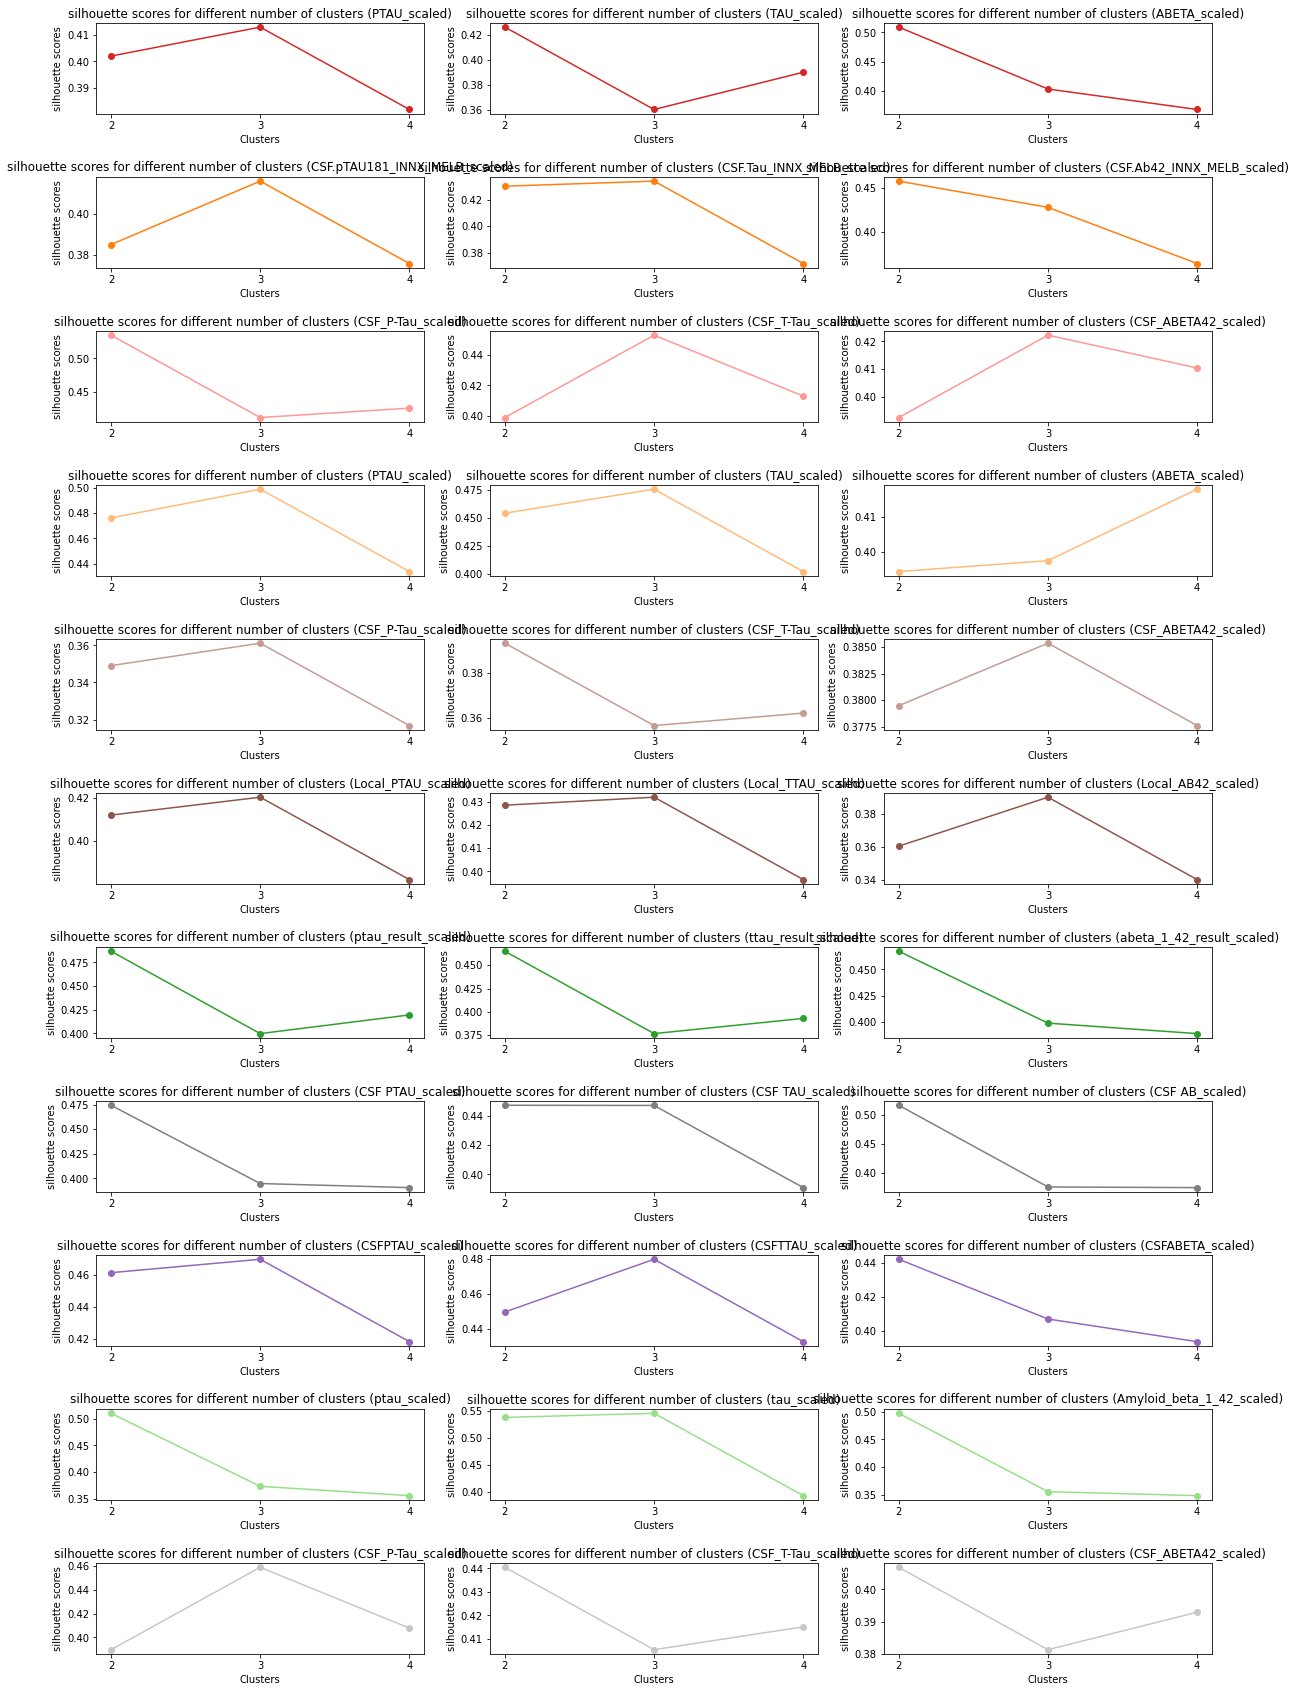

In [31]:
colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
          'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'I-ADNI': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
          'VITA': '#bcbd22', 'WMH-AD': '#dbdb8d', 'VASCULAR': '#9edae5', 'ABVIB': '#e0d9e2'}

fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting BIC scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], silhouette[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Clusters')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('silhouette scores')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'silhouette scores for different number of clusters ({i})')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xticks(hypersss[cohort][i])
    ind+=1

In [32]:
centroids = pd.DataFrame(index=cohorts_csf, columns= mappings['csf'].loc[:2]['Feature'].to_list())

In [33]:
for coh in cohorts_csf:
    for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][coh].to_list()]:

        # Set the model and its parameters
        model = KMeans(n_clusters=2, n_init=20)

        # Fit the model 
        clm = model.fit(cohorts_csf[coh][[biom, 'Age_scaled']])
        centroids.loc[coh, mappings['csf'].loc[mappings['csf'][coh]==biom.split('_scaled')[0], 'Feature']] = np.average((clm.cluster_centers_[0].tolist(), clm.cluster_centers_[1].tolist()), axis=0).tolist()[0]
#         print(coh, biom, np.average((clm.cluster_centers_[0].tolist(), clm.cluster_centers_[1].tolist()), axis=0).tolist()[0])
        cohorts_csf[coh][biom.split('_scaled')[0] + "_ATN"] = clm.predict(cohorts_csf[coh][[biom, 'Age_scaled']])

In [34]:
def reverse_standardization(dfs, cccs, csf_mappings):
    """
    dfs: a dictionary of dataframes where each df containes all CSF measurements, scaled CSF, etc. 
    cccs: df containing all cluster centers for all CSF biomarkers
    csf_mappings: harmonized mapping of CSF biomarkers among the investigated cohorts
    """
    
    for study in dfs:
        
        for biomarker in csf_mappings['csf'].iloc[:3][study].to_list():
    
            min_, max_ = np.min(dfs[study][biomarker]), np.max(dfs[study][biomarker])
            featu = csf_mappings['csf'].loc[csf_mappings['csf'][study]==biomarker, 'Feature']
            cccs.loc[study, featu + "_threshold"]= round(cccs.loc[study][featu].item() * (max_ - min_) + min_, 2)
            
    return cccs

In [35]:
centroids = reverse_standardization(cohorts_csf, centroids, mappings)

In [36]:
centroids[['A-beta 1-42 in CSF_threshold', 'pTau in CSF_threshold', 'tTau in CSF_threshold']]

,A-beta 1-42 in CSF_threshold,pTau in CSF_threshold,tTau in CSF_threshold
ADNI,1093.49,27.48,285.76
AIBL,689.90,77.72,635.31
ARWIBO,511.09,71.96,562.63
DOD-ADNI,1231.89,22.54,250.19
EDSD,781.71,82.78,577.67
EMIF,602.00,59.93,375.02
EPAD,1180.54,19.61,224.71
JADNI,414.27,61.99,147.55
NACC,479.43,48.30,233.66
PREVENT-AD,1150.35,50.33,301.58


In [37]:
centroids[['A-beta 1-42 in CSF_threshold', 'pTau in CSF_threshold', 'tTau in CSF_threshold']].to_csv("../results/cutoffs/km_cutoffs.csv")

### plot all clusters for each biomarker in each cohort

In [38]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in cohorts_csf:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
# #     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma in csf:
#         sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], kde=True)
# #         sns.scatterplot(x=cohorts_csf[ind]['Age'], y=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers_cluster.png", dpi=300)

In [39]:
centroids[['A-beta 1-42 in CSF_threshold', 'pTau in CSF_threshold', 'tTau in CSF_threshold']]

,A-beta 1-42 in CSF_threshold,pTau in CSF_threshold,tTau in CSF_threshold
ADNI,1093.49,27.48,285.76
AIBL,689.90,77.72,635.31
ARWIBO,511.09,71.96,562.63
DOD-ADNI,1231.89,22.54,250.19
EDSD,781.71,82.78,577.67
EMIF,602.00,59.93,375.02
EPAD,1180.54,19.61,224.71
JADNI,414.27,61.99,147.55
NACC,479.43,48.30,233.66
PREVENT-AD,1150.35,50.33,301.58


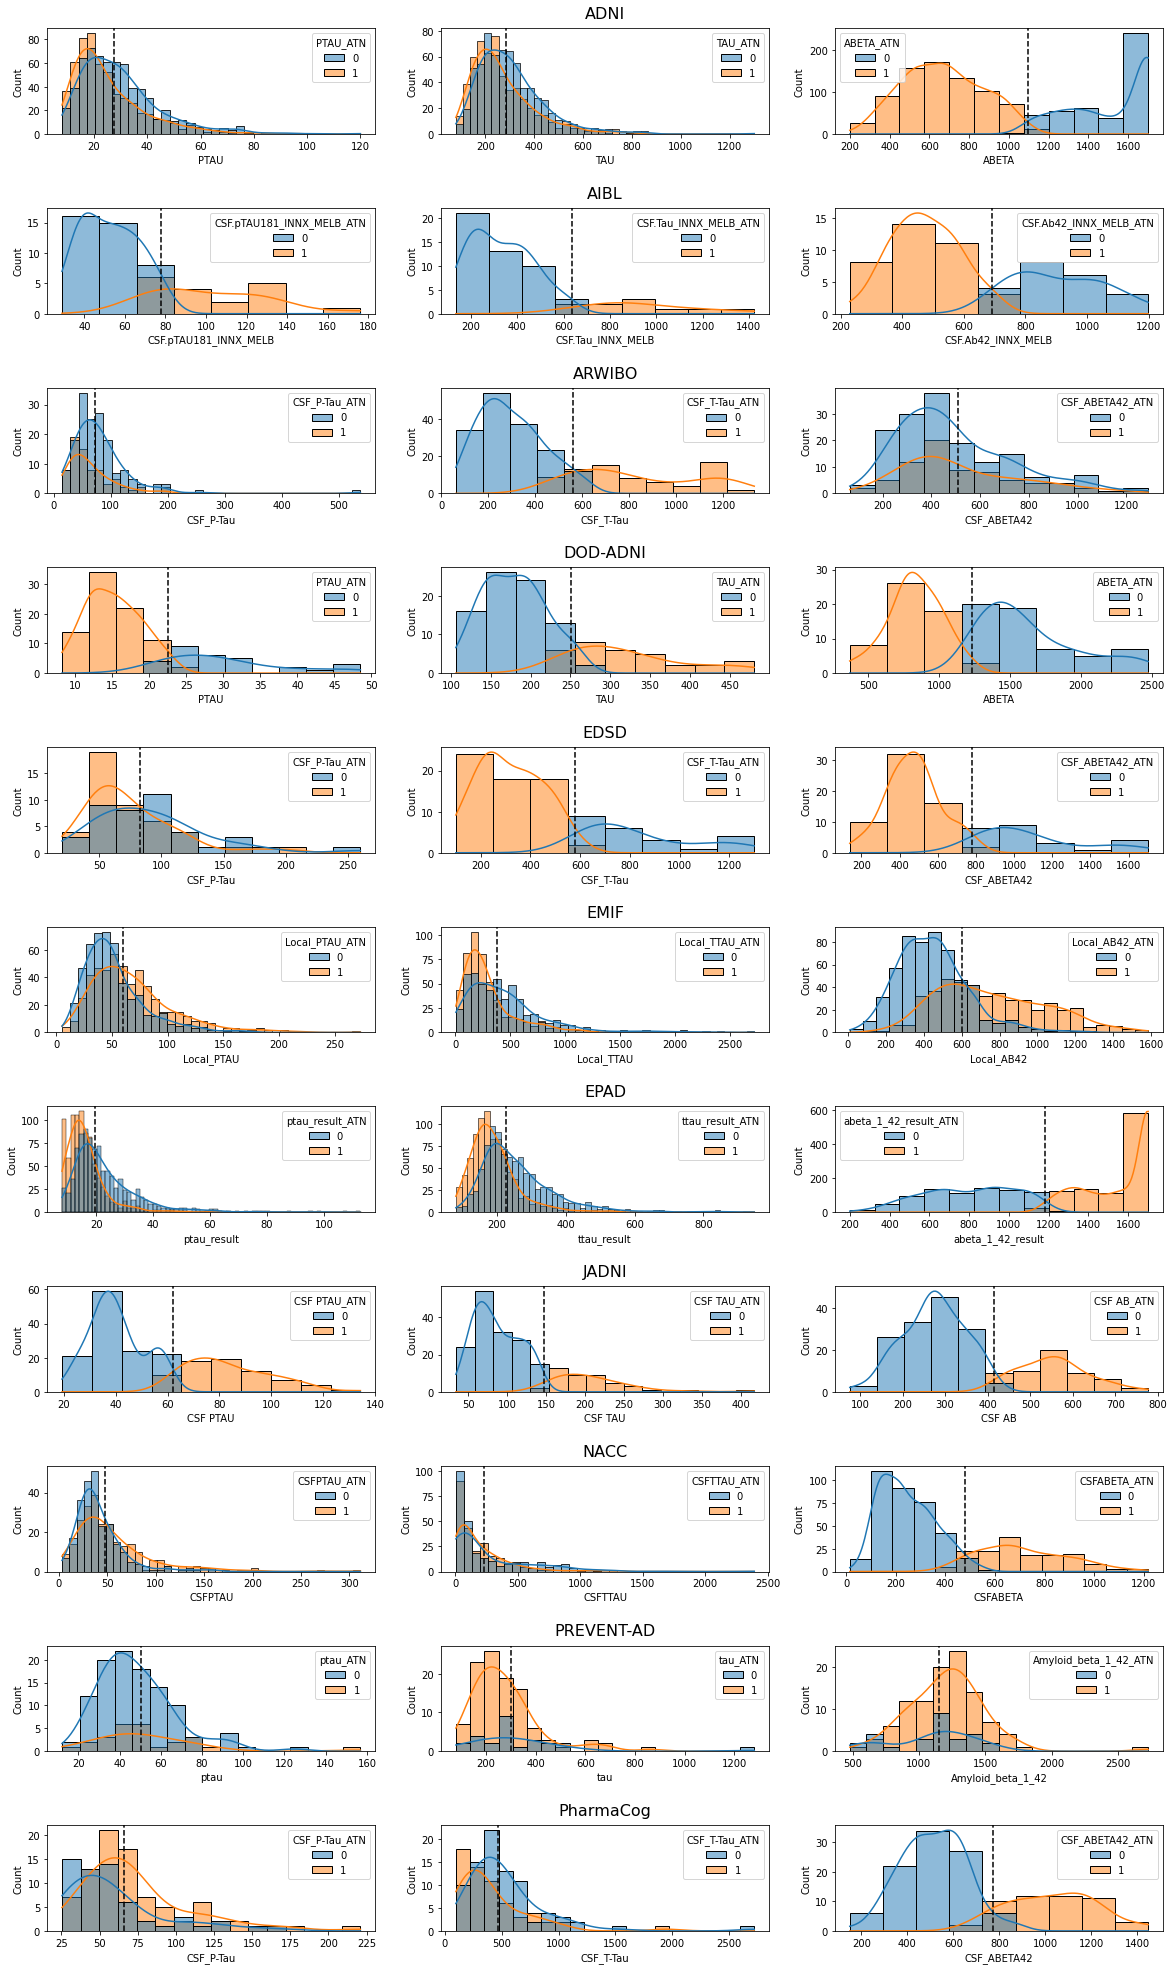

In [40]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma in csf:
        sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], kde=True)
        axes[i, csf.index(bioma)].axvline(x=centroids.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item() + "_threshold"], c='black', ls='--') 
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1

## ATN Profiles

In [41]:
bio_ = list()
for a in ['A', 'T', 'N']: 
    for b in ['+', '-']:
        bio_.append(a+b)
        
profiles_df = pd.DataFrame(index=centroids.index, columns=bio_)

classes = {i: pd.DataFrame(index=cohorts_csf[i].index, columns=['A', 'T', 'N']) for i in centroids.index}
for i in classes: classes[i].replace({np.nan: 0}, inplace=True)

In [42]:
for ind in centroids.index:
    
    for col, letter in zip(centroids.columns[:3], ['T', 'N', 'A']):
        threshold = centroids.loc[ind][col + "_threshold"]
        bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind].item()

        if letter == 'T': 
            profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
        elif letter == 'N': 
            profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
        else: 
            profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1

In [43]:
profiles_df

,A+,A-,T+,T-,N+,N-
ADNI,773,442,492,723,503,712
AIBL,35,22,15,42,10,47
ARWIBO,146,88,100,134,67,167
DOD-ADNI,55,58,28,85,34,79
EDSD,59,26,34,51,24,61
EMIF,628,385,403,611,376,638
EPAD,806,970,646,1130,678,1098
JADNI,140,57,71,126,45,152
NACC,352,154,181,325,158,348
PREVENT-AD,55,78,51,82,47,86


In [44]:
for i in classes:
    classes[i]['ATN'] = classes[i]['A'].astype(str) + classes[i]['T'].astype(str) + classes[i]['N'].astype(str)

In [45]:
final_profiles = pd.DataFrame(index=classes, columns=list(Counter(classes['ADNI']['ATN']).keys()))

In [46]:
for i in classes:
    profs = dict(Counter(classes[i]['ATN']))

    for pro in profs:
        final_profiles.loc[i, pro] = profs[pro]

In [47]:
final_profiles.rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)

In [48]:
final_profiles.replace({np.nan: 0}, inplace=True)
final_profiles = final_profiles[['A+T+N+', 'A-T-N-', 'A+T+N-', 'A+T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T-N+']]

In [49]:
final_profiles.to_csv("../results/k_means/final_profiles_kmeans.csv")

In [50]:
final_profiles

,A+T+N+,A-T-N-,A+T+N-,A+T-N-,A-T+N+,A-T-N+,A-T+N-,A+T-N+
ADNI,388,338,27,346,76,27,1,12
AIBL,8,17,3,24,1,1,3,0
ARWIBO,49,61,27,65,10,3,14,5
DOD-ADNI,9,36,1,42,18,4,0,3
EDSD,18,19,10,29,3,1,3,2
EMIF,247,247,37,321,86,20,33,23
EPAD,315,608,24,460,301,55,6,7
JADNI,42,56,29,67,0,1,0,2
NACC,63,65,67,207,42,38,9,15
PREVENT-AD,13,39,2,39,30,3,6,1


### Study-Reported Diagnosis of Patients in each ATN Profile

In [51]:
diag_vs_atn = {i: pd.DataFrame(columns=list(Counter(cohorts_csf['ADNI']['Diagnosis'])) + ['Unknown'], index=list(Counter(classes['ADNI']['ATN']))) for i in cohorts_csf}

In [52]:
for coh in classes:
    for i in list(Counter(classes[coh]['ATN'])):
        diag_vs_atn[coh].loc[i] = dict(Counter(cohorts_csf[coh].loc[classes[coh].loc[classes[coh]['ATN']==i].index, 'Diagnosis'].replace({np.nan: 'Unknown'})))

In [53]:
for i in diag_vs_atn: 
    diag_vs_atn[i] = diag_vs_atn[i].transpose()
    diag_vs_atn[i].rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)
    diag_vs_atn[i].replace({np.nan: 98989898}, inplace=True)
    diag_vs_atn[i] = diag_vs_atn[i].astype(int)
    diag_vs_atn[i].replace({98989898: '-'}, inplace=True)

In [54]:
for i in diag_vs_atn:
    diag_vs_atn[i] = diag_vs_atn[i][['A+T+N+', 'A-T-N-', 'A+T+N-', 'A+T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T-N+']]
    diag_vs_atn[i].to_csv("../results/k_means/diag_atn_km_" + f"{i}" + ".csv")

In [76]:
diag_vs_atn['PharmaCog']

,A+T+N+,A-T-N-,A+T+N-,A+T-N-,A-T+N+,A-T-N+,A-T+N-,A+T-N+
CU,-,-,-,-,-,-,-,-
MCI,43,40,9,41,5,4,-,3
AD,-,-,-,-,-,-,-,-
Unknown,-,-,-,-,-,-,-,-


## Testing 

### Abnormalities Reported by Cohort Studies

In [56]:
test = cohorts_csf['EMIF']

test['Local_TTAU_ATN'].replace({0: 2, 1: 0}, inplace=True)
test['Local_TTAU_ATN'].replace({2: 1}, inplace=True)

test['Local_AB42_ATN'].replace({0: 2, 1: 0}, inplace=True)
test['Local_AB42_ATN'].replace({2: 1}, inplace=True)

In [57]:
test['Local_PTAU_cutpoint'] = 0
test.loc[test['Local_PTAU'] > 56.5, 'Local_PTAU_cutpoint'] = 1

test['Local_TTAU_cutpoint'] = 0
test.loc[test['Local_TTAU'] > 296.5, 'Local_TTAU_cutpoint'] = 1

test['Local_AB42_cutpoint'] = 0
test.loc[test['Local_AB42'] < 638.5, 'Local_AB42_cutpoint'] = 1

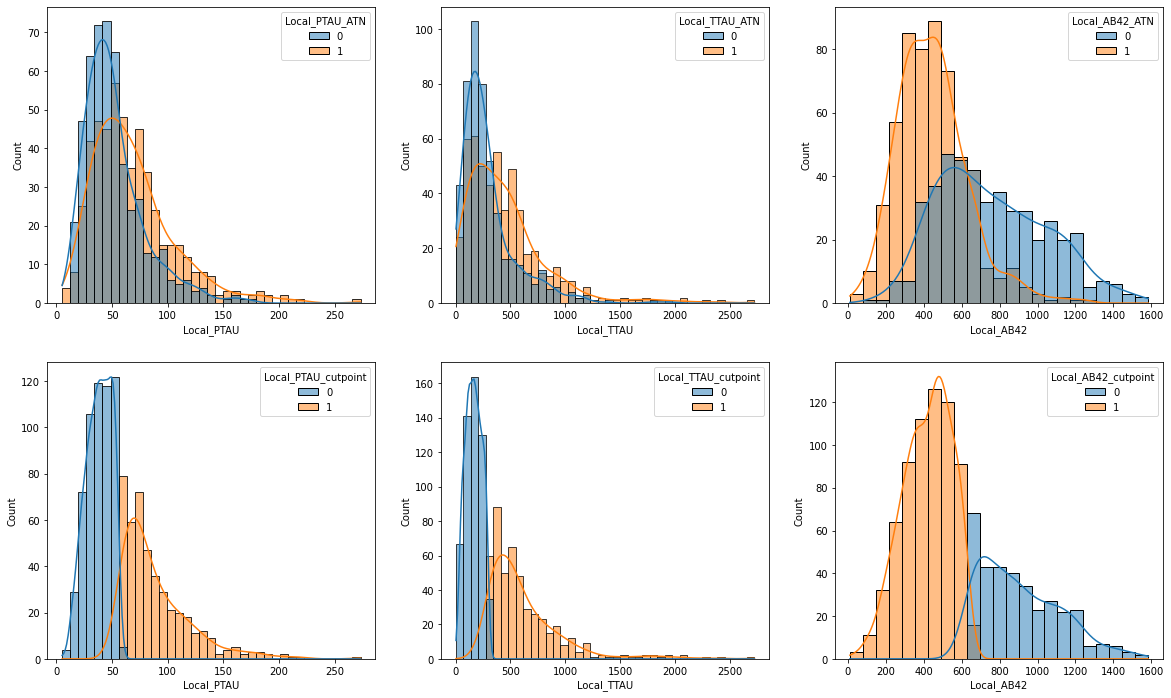

In [58]:
fig, axes = plt.subplots(2, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.2)
i=0


csf = mappings['csf'].iloc[:3]['EMIF'].to_list()

for bioma in csf:
#     sns.scatterplot(x=test['Age'], y=test[bioma], ax=axes[0, csf.index(bioma)], hue=test[bioma + "_ATN"])
#     sns.scatterplot(x=test['Age'], y=test[bioma], ax=axes[1, csf.index(bioma)], hue=test[bioma + "_cutpoint"])
    
    sns.histplot(x=test[bioma], ax=axes[0, csf.index(bioma)], hue=test[bioma + "_ATN"], kde=True)
    sns.histplot(x=test[bioma], ax=axes[1, csf.index(bioma)], hue=test[bioma + "_cutpoint"], kde=True)
    
i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

In [59]:
EDSD = cohorts_csf['EDSD']
EDSD['CSF_P-Tau_ATN'].replace({0: 2, 1: 0}, inplace=True)
EDSD['CSF_P-Tau_ATN'].replace({2: 1}, inplace=True)

EDSD['CSF_T-Tau_ATN'].replace({0: 2, 1: 0}, inplace=True)
EDSD['CSF_T-Tau_ATN'].replace({2: 1}, inplace=True)

EDSD['CSF_ABETA42_ATN'].replace({0: 2, 1: 0}, inplace=True)
EDSD['CSF_ABETA42_ATN'].replace({2: 1}, inplace=True)

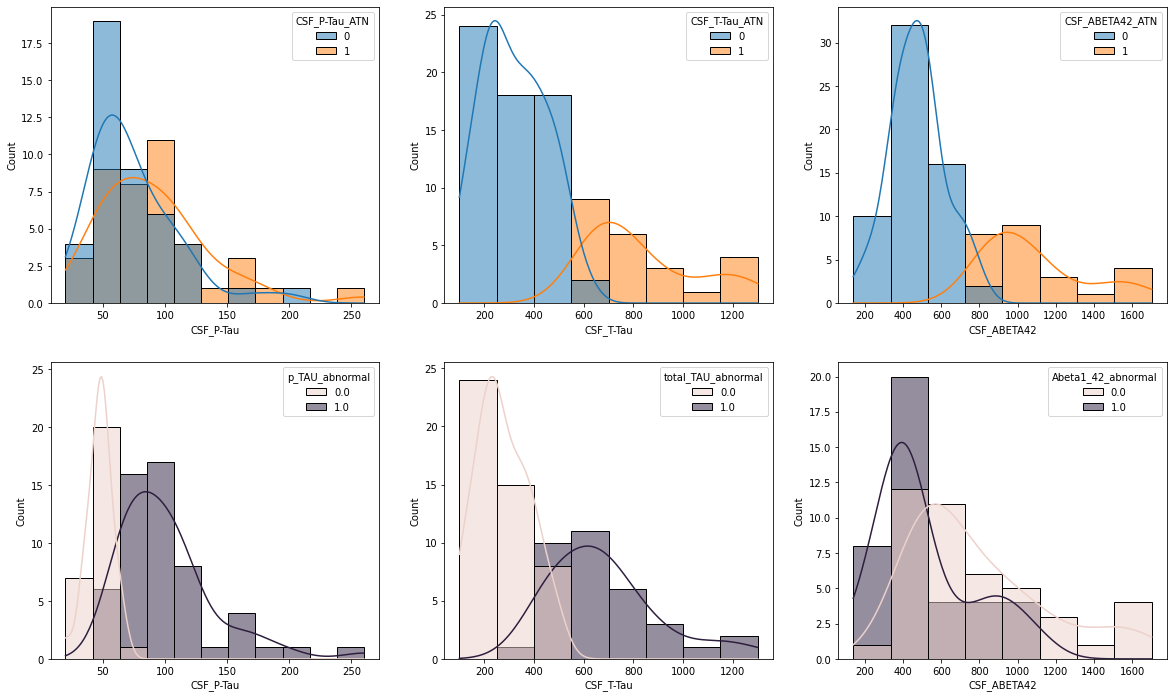

In [60]:
fig, axes = plt.subplots(2, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.2)
i=0


csf = mappings['csf'].iloc[:3]['EDSD'].to_list()
abnormality = ['p_TAU_abnormal', 'total_TAU_abnormal', 'Abeta1_42_abnormal']

for bioma, abnor in zip(csf, abnormality):
#     sns.scatterplot(x=EDSD['Age'], y=EDSD[bioma], ax=axes[0, csf.index(bioma)], hue=EDSD[bioma + "_ATN"])
#     sns.scatterplot(x=EDSD['Age'], y=EDSD[bioma], ax=axes[1, csf.index(bioma)], hue=cohort_studies['EDSD'][abnor])
    
    sns.histplot(x=EDSD[bioma], ax=axes[0, csf.index(bioma)], hue=EDSD[bioma + "_ATN"], kde=True)
    sns.histplot(x=EDSD[bioma], ax=axes[1, csf.index(bioma)], hue=cohort_studies['EDSD'][abnor], kde=True)
    
    
#     sns.kdeplot(x=EDSD[bioma], ax=axes[0, csf.index(bioma)], hue=EDSD[bioma + "_ATN"])
#     sns.kdeplot(x=EDSD[bioma], ax=axes[1, csf.index(bioma)], hue=cohort_studies['EDSD'][abnor])
    
i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

In [61]:
for ind in centroids.index:
    
    for col, letter in zip(centroids.columns[:3], ['T', 'N', 'A']):
        threshold = centroids.loc[ind][col + "_threshold"]
        bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind].item()

        if letter == 'T': 
            profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
        elif letter == 'N': 
            profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
        else: 
            profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1

In [62]:
cohort_studies['EDSD'] = cohort_studies['EDSD'].dropna(subset=abnormality)

In [63]:
print(sum(Counter(cohort_studies['EDSD']['Abeta1_42_abnormal'].astype(int).astype(str) + cohort_studies['EDSD']['p_TAU_abnormal'].astype(int).astype(str) + cohort_studies['EDSD']['total_TAU_abnormal'].astype(int).astype(str)).values()))

82


In [64]:
{'011': 18, '100': 14, '111': 14, '000': 13, '110': 11, '010': 10, '001': 2}

{'011': 18, '100': 14, '111': 14, '000': 13, '110': 11, '010': 10, '001': 2}

In [65]:
sum(final_profiles.loc['EDSD'])

85